# Longitudinal QuasiCopula GWAS with Mixed Marginals

Here we will use autodiff to compute all gradient/Hessian terms (e.g. Q, W, R) and see if that gives good p-values. 

In [33]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots
ENV["COLUMNS"] = 240

BLAS.set_num_threads(1)
Threads.nthreads()

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end

_make_snparray (generic function with 1 method)

## Simulate data

In [37]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d = 2, # number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
    βtrue = [1.0; rand(-0.03:0.06:0.03, p-1)]
    dist = y_distribution()
    link = canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.1, m)

    # simulate design matrices
    Random.seed!(seed)
    X_full = Matrix{Float64}[]
    for i in 1:n
        nobs = rand(1:d) # number of obs for this sample
        push!(X_full, hcat(ones(nobs), randn(nobs, p - 1)))
    end

    # simulate random SnpArray with q SNPs and randomly choose k SNPs to be causal
    Random.seed!(2022)
    G = simulate_random_snparray(undef, n, q)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    γtrue = zeros(q)
    γtrue[1:k] .= rand([-0.2, 0.2], k)
    shuffle!(γtrue)
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 10.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, size(X, 1))
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            for i in 1:size(X, 1)
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, size(X, 1))
            res = Vector{T}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    else
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            vecd = Vector{DiscreteUnivariateDistribution}(undef, size(X, 1))
            for i in 1:size(X, 1)
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, size(X, 1))
            res = Vector{T}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, G, βtrue, θtrue, γtrue
end

k = 0 # number of causal SNPs

qc_model, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 5000, # sample size
    d = 5, # max number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Bernoulli
  * link function: LogitLink
  * number of clusters: 5000
  * cluster size min, max: 1, 5
  * number of variance components: 2
  * number of fixed effects: 3



## Fit Null model

In [38]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 200,
        accept_after_max_steps = 10,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="second-order"
    )
);

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        5
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [39]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

βtrue = [1.0, -0.03, 0.03]
qc_model.β = [0.9787109971992247, -0.006534895264500844, 0.004756529558569876]
qc_model.∇β = [-1.2530390755549625e-6, 8.717288488488406e-7, -9.137386014490545e-7]
θtrue = [0.1, 0.1]
qc_model.θ = [0.09068628793643643, 0.050371173525735724]
qc_model.∇θ = [1.0514365018088334e-6, 9.835424232274015e-7]


# Loglikelihood function friendly to autodiff

In [176]:
autodiff_loglikelihood(β) = QuasiCopula.loglikelihood(β, qc_model, z)

# autodiff Gradient
∇logl = x -> ForwardDiff.gradient(autodiff_loglikelihood, x)

# autodiff Hessian
∇²logl = x -> ForwardDiff.hessian(autodiff_loglikelihood, x)

#75 (generic function with 1 method)

First, check if `autodiff_loglikelihood` returns same answer as `QuasiCopula.loglikelihood!`

In [177]:
i = 1
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
fullβ = [qc_model.β; qc_model.θ; 0.0] # poisson or bernoulli
# fullβ = [qc_model.β; qc_model.θ; qc_model.τ; 0.0] # normal

@show autodiff_loglikelihood(fullβ)
@show QuasiCopula.loglikelihood!(qc_model, false, false);

autodiff_loglikelihood(fullβ) = -9115.213958968148
QuasiCopula.loglikelihood!(qc_model, false, false) = -9115.21395896794


Lets compute a few Hessians

In [178]:
i = 1
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 1

6×6 Matrix{Float64}:
 -1919.15         1.51325       1.59757    1597.48     1575.14       -1.0216
     1.51325  -2260.8          -0.233382    -14.0315     12.8902     -1.21421
     1.59757     -0.233382  -2269.25         24.4981     -1.36837     1.91114
  1597.48       -14.0315       24.4981    -7326.05      169.748     -28.6415
  1575.14        12.8902       -1.36837     169.748   -1791.56        3.10195
    -1.0216      -1.21421       1.91114     -28.6415      3.10195  -204.705

In [179]:
# check correlation between VC params and beta
i, j = 1, 4
@show -Hfull[i, j] / sqrt(-Hfull[i, i]) / sqrt(-Hfull[j, j])
i, j = 1, 5
@show -Hfull[i, j] / sqrt(-Hfull[i, i]) / sqrt(-Hfull[j, j]);

(-(Hfull[i, j]) / sqrt(-(Hfull[i, i]))) / sqrt(-(Hfull[j, j])) = -0.42603436300632386
(-(Hfull[i, j]) / sqrt(-(Hfull[i, i]))) / sqrt(-(Hfull[j, j])) = -0.849472198131595


In [180]:
i = 10
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 10

6×6 Matrix{Float64}:
 -1919.15         1.51325       1.59757    1597.48     1575.14       -2.87847
     1.51325  -2260.8          -0.233382    -14.0315     12.8902    -16.2479
     1.59757     -0.233382  -2269.25         24.4981     -1.36837    -6.57504
  1597.48       -14.0315       24.4981    -7326.05      169.748     -75.1647
  1575.14        12.8902       -1.36837     169.748   -1791.56      -29.2314
    -2.87847    -16.2479       -6.57504     -75.1647    -29.2314   -650.334

In [181]:
# check correlation between VC params and beta
i, j = 1, 4
@show -Hfull[i, j] / sqrt(-Hfull[i, i]) / sqrt(-Hfull[j, j])
i, j = 1, 5
@show -Hfull[i, j] / sqrt(-Hfull[i, i]) / sqrt(-Hfull[j, j]);

(-(Hfull[i, j]) / sqrt(-(Hfull[i, i]))) / sqrt(-(Hfull[j, j])) = -0.42603436300632386
(-(Hfull[i, j]) / sqrt(-(Hfull[i, i]))) / sqrt(-(Hfull[j, j])) = -0.849472198131595


In [182]:
W = -Hfull[1:end-1, end]
Q = -Hfull[end, end]
Pinv = inv(-Hfull[1:end-1, 1:end-1])
R = ∇logl(fullβ)[end]
S = R * inv(Q - W'*Pinv*W) * R
pval = ccdf(Chisq(1), S)

0.15105678954408971

In [183]:
∇logl(fullβ)

6-element Vector{Float64}:
 -2.1122262966466465e-8
 -1.5168279158747633e-8
  3.1197817593198174e-10
  3.4941168847169024e-9
  1.312742081704954e-8
 36.03130779123372

## Check QQ plots

### Bernoulli

In [28]:
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

 21.319460 seconds (61.53 k allocations: 39.535 MiB, 0.70% gc time)


1000-element Vector{Float64}:
 0.5644992405065378
 0.15784782604423747
 0.8442310060062539
 0.8817716309480466
 0.9253274498146944
 0.003506126780287953
 0.7525868989191161
 0.4808044534741639
 0.17829570739969267
 0.4514367047131067
 0.22250887361486982
 0.3255808777775815
 0.1900639430575561
 ⋮
 0.39395746870849074
 0.5522937484340259
 0.8241304600781619
 0.8738489816793037
 0.8132807451906705
 0.6524462851961218
 0.6984092483952774
 0.18675785726392038
 0.5768906695664822
 0.17807939386765723
 0.052952129790720226
 0.12334946298195286

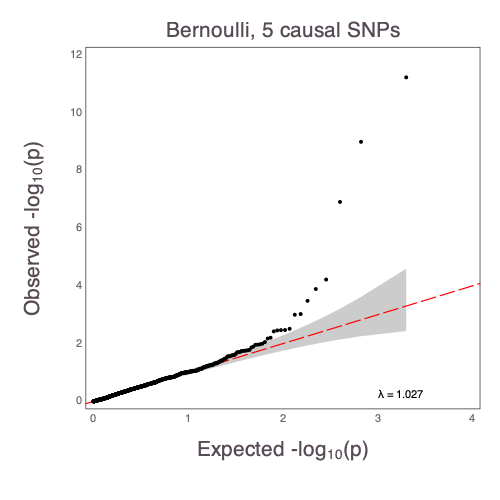

In [29]:
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

In [30]:
correct_snps = findall(!iszero, γtrue)
signif_snps = findall(x -> x < 0.05/length(pvals), pvals)
power = length(correct_snps ∩ signif_snps) / max(1, length(correct_snps))

@show length(signif_snps)
@show power

length(signif_snps) = 3
power = 0.6


0.6

In [31]:
# pvalues of truly causal SNPs
pvals[correct_snps] |> sort

5-element Vector{Float64}:
 6.0331516392201864e-12
 1.030589749790029e-9
 1.245201995216175e-7
 6.0609490412980606e-5
 0.06188612423675687

In [32]:
# pvalues of all SNPs sorted by significance
sort(pvals)

1000-element Vector{Float64}:
 6.0331516392201864e-12
 1.030589749790029e-9
 1.245201995216175e-7
 6.0609490412980606e-5
 0.00012906537690192047
 0.000331180393985165
 0.0009485421979176238
 0.001001948213653033
 0.0030760512222149992
 0.003389791304748053
 0.003421471179503189
 0.003506126780287953
 0.0037835366534109483
 ⋮
 0.9938415194112987
 0.9941186065853664
 0.9943587142624726
 0.9949164122191888
 0.9961728811790946
 0.996690676521285
 0.9970745110526468
 0.9972109487313688
 0.9979018920841659
 0.999261461518929
 0.9992654116919657
 0.9999816841249722

### Poisson

In [140]:
@time pvals = GWASCopulaVCModel_autodiff(qc_model, G)

 28.589258 seconds (11.94 M allocations: 665.492 MiB, 1.92% gc time, 10.78% compilation time)


1000-element Vector{Float64}:
 0.6114268725266863
 0.1070897825482224
 0.4808221686158258
 0.744190834942224
 0.950482348827627
 0.23528673084794868
 0.46045653681006116
 0.45866209289578674
 0.9258876193751494
 0.8627151681348451
 0.15372568300464257
 0.5204998859286512
 0.7626078790033816
 ⋮
 0.9035329323344029
 0.6592685362102048
 0.3928055101450575
 0.7713633298069937
 0.2389535335631845
 0.21632316805960078
 0.5398714872768096
 0.7179613000061875
 0.2610477871041082
 0.1960121426222287
 0.2119757709621244
 0.2488841786630273

In [142]:
correct_snps = findall(!iszero, γtrue)
signif_snps = findall(x -> x < 0.05/length(pvals), pvals)
power = length(correct_snps ∩ signif_snps) / max(1, length(correct_snps))

@show length(signif_snps)
@show power

length(signif_snps) = 0
power = 0.0


0.0

In [143]:
# pvalues of truly causal SNPs
pvals[correct_snps] |> sort

Float64[]

In [144]:
# pvalues of all SNPs sorted by significance
sort(pvals)

1000-element Vector{Float64}:
 7.774419750037377e-5
 0.0007995735158536389
 0.0014701534337042362
 0.0023052624910533167
 0.0032960856216279174
 0.0045025374492216885
 0.007228559546037386
 0.00871530231445743
 0.009464796774703342
 0.009500401842390423
 0.010496950215314155
 0.012832798228600159
 0.013572084093715341
 ⋮
 0.9920031583740274
 0.9929075203129113
 0.992935227855631
 0.9929518639402093
 0.9952200936210467
 0.9955531576454074
 0.995731012918804
 0.9964340911964977
 0.9968085641471957
 0.9988088543252713
 0.9995714607152042
 0.9998427630853882

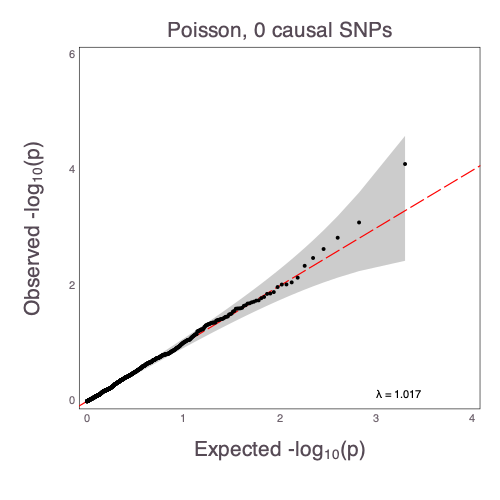

In [145]:
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs")
display("image/png", read("qqplot.png"))

### Normal

In [161]:
@time pvals = GWASCopulaVCModel_autodiff(qc_model, G)

 25.604872 seconds (2.98 M allocations: 189.687 MiB, 0.09% gc time, 2.54% compilation time)


1000-element Vector{Float64}:
 0.24465953017198147
 0.009741891736981027
 0.7567517986287128
 0.4535554720965867
 0.3452760068789352
 0.5307896341388307
 0.9904425612163903
 0.5069914738526093
 0.26311222865636374
 0.492781311235218
 0.6944152891166855
 0.9110781982219424
 0.6676099440726022
 ⋮
 0.9621950407729223
 0.30575034422284897
 0.8554907435007886
 0.47056664465245246
 0.21058684775370182
 0.30712783776048014
 0.71620468448529
 0.7427197831010647
 0.9002203228180086
 0.15077039902942807
 0.7941846237269187
 0.06887147552189807

In [162]:
correct_snps = findall(!iszero, γtrue)
signif_snps = findall(x -> x < 0.05/length(pvals), pvals)
power = length(correct_snps ∩ signif_snps) / max(1, length(correct_snps))

@show length(signif_snps)
@show power

length(signif_snps) = 0
power = 0.0


0.0

In [163]:
# pvalues of truly causal SNPs
pvals[correct_snps] |> sort

Float64[]

In [164]:
# pvalues of all SNPs sorted by significance
sort(pvals)

1000-element Vector{Float64}:
 0.0012751656205525225
 0.0016027816489660603
 0.0028623669696721914
 0.003959580728971236
 0.0052060611954021984
 0.006395370251445862
 0.007019073586846049
 0.007134156007834394
 0.009741891736981027
 0.010386259143514922
 0.010426917301049974
 0.01065502403732776
 0.012274771875088185
 ⋮
 0.9880104822446031
 0.9904425612163903
 0.9905189519417772
 0.9906432097326853
 0.9923209905422546
 0.9927615390304259
 0.9933161413567163
 0.9941293211269938
 0.9945405005876492
 0.9953517907746027
 0.9976181881079547
 0.9988153189582745

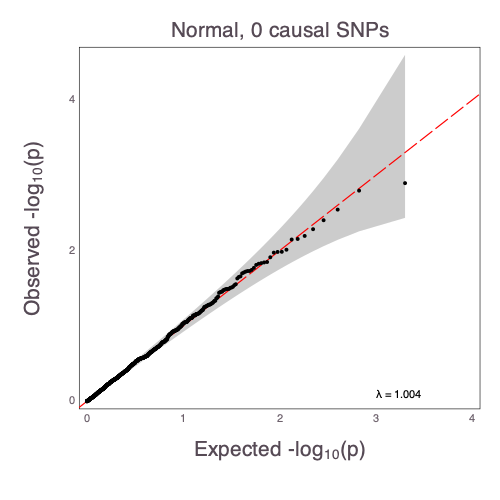

In [165]:
qq(pvals, dpi=100, titles="Normal, $k causal SNPs")
display("image/png", read("qqplot.png"))